In [3]:
from yahoo_finance_api2 import share
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.spatial.distance import euclidean
import seaborn as sns
import numpy as np
import tsfresh as fresh
import tslearn as tsl
import pandas as pd
from itertools import product, combinations
from tsfresh.utilities.dataframe_functions import impute
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from tslearn.metrics import dtw

In [4]:
from IPython.display import set_matplotlib_formats

set_matplotlib_formats('retina')
sns.set(style="darkgrid")
%matplotlib inline

# Introdução

Uma das aplicações mais comuns de machine learning é na previsão de séries temporais, seja na detecção de anomalias em um ECG, previsão de vendas futuras ou de ações do mercado financeiro. Neste trabalho tentaremos prever o valor futuro das ações correspondetes ao indice iBovespa com uma janela de 7 dias utilizando de [AutoML](https://docs.microsoft.com/en-us/azure/machine-learning/service/concept-automated-ml).

# Sumario

# Helpers
As funções a seguir serão convenientes mais adiante.

In [5]:
def format_unix_time(timestamp):
    """
    Retorna yyyy-mm-dd a partir de um unix timestamp
    """
    return datetime.date(datetime.fromtimestamp(timestamp))

def date_missing(series, freq):
    """
    Retorna uma serie temporal booleana que indica a presenca de valores na serie original
    para cada data
    """
    all_dates = pd.Series(data=pd.date_range(start=series["timestamp"].min(),
                                             end=series["timestamp"].max(),
                                             freq=freq))
    date_is_missing = all_dates.isin(series["timestamp"].values)


    return pd.DataFrame({
        "timestamp": all_dates,
        "date_missing": ~date_is_missing
    })

def get_ticker_history(ticker):
    """
    Retorna historico de uma acao nos ultimos 5 anos
    """
    return share.Share(ticker).get_historical(share.PERIOD_TYPE_YEAR,
                                              5,
                                              share.FREQUENCY_TYPE_DAY,
                                              1)

def get_tickers_history(tickers):
    """
    Retorna historico de multiplas acoes nos ultimos 5 anos
    """
    df = pd.DataFrame(get_ticker_history(tickers[0])).assign(ticker=tickers[0])
    for i in range(1, len(tickers)):
        ticker = tickers[i]
        ticker_history = get_ticker_history(ticker)
        nth_df = pd.DataFrame(ticker_history).assign(ticker=ticker)
        df = pd.concat([df, nth_df], axis=0, sort=False)
    return df

# Obtendo os dados

## Componentes do nasdaq-100

NASDAQ-100 corresponde as 100 empresas com os melhores resultados na bolsa de New York (NASDAQ).
A lista com componentes desse indice foi obtida no [Yahoo Finance](https://finance.yahoo.com/quote/%5ENDX/components?p=%5ENDX).

Essas foram as ações que inicialmente iamos prever. Após alguns testes decidimos prever ações da BOVESPA, mas os resultados de tais testes não deixam de ser relevantes.

In [6]:
nasdaq_100 = ["ATVI","ADBE","AMD","ALXN","ALGN","GOOGL","GOOG","AMZN","AAL","AMGN","ADI","AAPL","AMAT","ASML","ADSK","ADP","BIDU","BIIB","BMRN","BKNG","AVGO","CSX","CDNS","CELG","CERN","CHTR","CHKP","CTAS","CSCO","CTXS","CTSH","CMCSA","COST","CTRP","DLTR","EBAY","EA","EXPE","FB","FAST","FISV","FOXA","FOX","GILD","HAS","HSIC","IDXX","ILMN","INCY","INTC","INTU","ISRG","JBHT","JD","KLAC","KHC","LRCX","LBTYA","LBTYK","LULU","MAR","MXIM","MELI","MCHP","MU","MSFT","MDLZ","MNST","MYL","NTAP","NTES","NFLX","NVDA","NXPI","ORLY","PCAR","PAYX","PYPL","PEP","QCOM","REGN","ROST","SIRI","SWKS","SBUX","SYMC","SNPS","TMUS","TTWO","TSLA","TXN","ULTA","UAL","VRSN","VRSK","VRTX","WBA","WDC","WLTW","WDAY","WYNN","XEL","XLNX"]

## Componentes da ibovespa
De forma analoga a nasdaq-100, a [IBOVESPA](http://www.bmfbovespa.com.br/pt_br/produtos/indices/indices-amplos/indice-ibovespa-ibovespa-composicao-da-carteira.htm) corresponde as ações de maior sucesso na BOVESPA.

In [7]:
ibov = ['ABEV3.SA', 'AZUL4.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA', 'BBSE3.SA', 'BPAC11.SA', 'BRAP4.SA', 'BRDT3.SA', 'BRFS3.SA', 'BRKM5.SA', 'BRML3.SA', 'BTOW3.SA', 'CCRO3.SA', 'CIEL3.SA', 'CMIG4.SA', 'CSAN3.SA', 'CSNA3.SA', 'CVCB3.SA', 'CYRE3.SA', 'ECOR3.SA', 'EGIE3.SA', 'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'EQTL3.SA', 'FLRY3.SA', 'GGBR4.SA', 'GNDI3.SA', 'GOAU4.SA', 'GOLL4.SA', 'HYPE3.SA', 'IGTA3.SA', 'IRBR3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KLBN11.SA', 'KROT3.SA', 'LAME4.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'MRVE3.SA', 'MULT3.SA', 'NATU3.SA', 'PCAR4.SA', 'PETR3.SA', 'PETR4.SA', 'QUAL3.SA', 'RADL3.SA', 'RAIL3.SA', 'RENT3.SA', 'SANB11.SA', 'SBSP3.SA', 'SMLS3.SA', 'SUZB3.SA', 'TAEE11.SA', 'TIMP3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIVT4.SA', 'VVAR3.SA', 'WEGE3.SA', 'YDUQ3.SA']

In [8]:
df = get_tickers_history(ibov)

## Coluna timestamp
A coluna timestamp será traduzida de UNIX time para o objeto datetime.date, que pode ser entendido pelo pandas.

In [9]:
df["timestamp"] = pd.to_datetime(df["timestamp"].apply(lambda row: format_unix_time(row/1000)))

## Semana de teste
Como o modelo foi de fato treinado dia 23, os dias 24-27 serão utilizados como validação.

Vale lembrar que o processo de treinamento com AutoML já realiza testes com validação cruzada, esse conjunto de validação será utilizado apenas para verificar a eficacia do modelo no mundo real, pois seu treinamento aconteceu antes desses dados existirem de fato.

In [10]:
df_test = df.tail(5).copy()
df.drop(df.tail(5).index, inplace=True)

In [11]:
df.tail(5)

,timestamp,open,high,low,close,volume,ticker
32,2019-09-17,33.509998,34.330002,33.279999,33.860001,1010100.0,YDUQ3.SA
33,2019-09-18,33.720001,34.169998,33.169998,34.169998,926900.0,YDUQ3.SA
34,2019-09-19,34.200001,35.360001,34.040001,35.080002,1513300.0,YDUQ3.SA
35,2019-09-20,35.080002,35.240002,34.419998,34.869999,2511600.0,YDUQ3.SA
36,2019-09-23,34.470001,35.330002,34.419998,35.200001,747100.0,YDUQ3.SA


## Salvando os dados em disco

O dataset de entrada para treinamento com AutoML na interface do Azure Cloud pode ser um arquivo CSV. Por esse ser o metodo mais facil, salvaremos o dataframe como CSV e utilizaremos esse arquivo na hora do treinamento.

In [12]:
df_nasdaq = get_tickers_history(nasdaq_100)
df_nasdaq.drop(df_nasdaq.tail(5).index, inplace=True)

In [13]:
df_nasdaq.to_csv("nasdaq_100.csv")
df.to_csv("ibovespa.csv")

# O primeiro experimento

Com o objetivo de estabelecer um baseline para o que AutoML tem a oferecer, realizamos um primeiro experimento utilizando o dataset `df_nasdaq` sem nenhum pre-processamento.

Foram escolhidos os seguites parametros: 

```json
{
    "task": "forecasting",
    "X": ["timestamp", "close", "open", "volume", "ticker"],
    "Y": "close",
    "primary_metric": "normalized_root_mean_squared_error",
    "blacklist_models": ["KNN"]
}
```

O `compute target` foi uma instancia do tipo `STANDARD_DS5_V2`, com 16 núcleos e 56GB de RAM 

## Os resultados

O grafico a seguir mostra o resultado da metrica primaria para diversos algoritmos que foram testados automaticamente. O melhor resultado obtido obteve `mean_square_error` de 101 um `r2` de 0.87.

![Iterações](./assets/nasdaq-100-iterations.png)

O gráfico de valores previstos X valores reais mostra que o resultado final não é muito satisfatorio em termos reais.

![Iterações](./assets/nasdaq-100-pred-true.png)

# O segundo experimento

Após analisar os resultados do primeiro experimento e pensar um pouco a respeito do nosso dataset, decidimos testar o algoritmo de AutoML com um numero menor de séries, na esperança de que um dataset mais homogênio resulte em métricas mais aceitaveis. 

Decidimos então utilizar um subconjunto do dataset original: séries da Apple - AAPL - e AMD.

Foram escolhidos os seguintes parametros:

```json
{
    "task": "forecasting",
    "X": ["timestamp", "close", "open", "volume", "ticker"],
    "Y": "close",
    "primary_metric": "normalized_root_mean_squared_error",
}
```

## Os resultados

Os melhores resultados foram obtidos com variações de arvore de decisão.

![aapl-amd-iterations](./assets/aapl-amd-iterations.png)

A divergencia dos valores reais e previstos foi significativamente menor que os resultados do primeiro experimento, corroborando com a hipotese de que com um dataset mais homogenio resulta em melhores metricas no caso da aplicação de AutoML para previsão financeira.

Tambem é possivel que o fato de as ações escolhidadas - Apple e AMD - serem relativamente estáveis ao longo do tempo e possuírem um padrão sazonal, com crescimento após as conferencias anuais, tenham ajudado na obtenção de resultados tão bons, com `root_mean_squared_error` de 1.35 e `r2` de 0.99.

![aapl-amd-pred-true](./assets/aapl-amd-pred-true.png)

# Limpando dados

Os resultados do primeiro  e segundo experimento indicam que AutoML deve ser utilizado após algum pre-processamento especifico para o tipo de problema em questão, o que é compatível com o visto na literatura/documentação oficial.

Ao analisar os logs de atividade do experimento 1 foi percebido que no pre-processamento automatico é realizado imputing, ou seja são preenchidos dados ausentes. Logo **lidar com dados ausentes** será uma etapa que realizaremos manualmente, buscando evitar introdução de ruído ou bias.

Além disso, percebemos no artigo [Computational Intelligence and Financial Markets: A Survey and Future Directions](https://www.sciencedirect.com/science/article/pii/S095741741630029X) que uma etapa de **clusterização de series semelhantes** é mencionada em diversos trabalhos relacionados.

Logo essas duas etapas serão realizadas antes de um terceiro experimento.

## Dados ausentes
Primeiro tentaremos eliminar o problema de possiveis dados ausentes.

### Atributos incompletos

In [14]:
bad_tickers = df[df.isna().any(axis=1)]["ticker"].unique()
print(bad_tickers)

['AZUL4.SA' 'SANB11.SA' 'SUZB3.SA']


Serão desconsideradas as series que possuem dados faltando

In [15]:
df = df[~df["ticker"].isin(bad_tickers)]

### Amostras ausentes no eixo temporal

Alem de dados faltando no nivel de atributos, devemos verificar tambem se existem muitos dados ausentes no eixo temporal, e se tais lacunas são nos mesmos pontos do tempo para todas as series.

Primeiro devemos verificar se o numero de amostragens de cada ticker é o mesmo, removendo tickers que falhem esse teste.

In [16]:
freq = df["ticker"].value_counts()
bad_tickers = freq[freq.lt(freq.max())].index.values

df = df[~df["ticker"].isin(bad_tickers)]

Será gerada uma serie temporal completa entre o primeiro e o ultimo dia visto no dataframe, essa serie completa será então comparada com os dados reais para identificar lacunas no eixo temporal.

In [17]:
unique_tickers = df["ticker"].unique()
missing_series = date_missing(df[df["ticker"] == unique_tickers[0]], "D")

In [18]:
missing_series.head(15)

,timestamp,date_missing
0,2014-10-01,False
1,2014-10-02,False
2,2014-10-03,False
3,2014-10-04,True
4,2014-10-05,True
5,2014-10-06,False
6,2014-10-07,False
7,2014-10-08,False
8,2014-10-09,False
9,2014-10-10,False


As linhas que estão ausentes correspondem a finais de semana e feriados, como no Brasil há apenas uma bolsa - BOVESPA -, espera-se que as series temporais estejam com amostragens faltando exatamente no mesmos pontos. Para garantir esse fato, façamos o teste.

In [19]:
bad_tickers = []
for ticker in unique_tickers:
    bad_ticker = (date_missing(df[df["ticker"] == ticker], "D") == missing_series)
    if not bad_ticker.all().all():
        bad_tickers.append(ticker)
bad_tickers

[]

Todos os valores ausentes estão temporalmente alinhados

In [20]:
print("Ainda sobraram {} series apos a eliminação de series com dados ausentes".format(len(df.ticker.unique())))

Ainda sobraram 57 series apos a eliminação de series com dados ausentes


# Clustering

Metodos de clusterização para series temporais sao catalogados no artigo [Time-series clustering – A decade review](https://www.sciencedirect.com/science/article/pii/S0306437915000733). 

Esse artigo elenca um pipeline genérico para o processo de clusterização de séries temporais, com seus principais componentes sendo:

1. Representação alternativa ou tratamento de qualidade dos dados
2. Medição de distancias
3. Metodo de clustering

Para o primeiro passo não iremos aplicar nenhuma transformação no dominio dos dados, realizando apenas a eliminação de series incompletas - o que ja foi feito.

Para o segundo passo foi optado por testar duas possibilidades:

1. DTW - Dynamic Time Warping
    
> Com essa medida de distancia series com comportamentos parecidos são medidas como próximas mesmo que suas semelhanças tenham acontecido em um tempo ou escala diferente.

2. Feature-based 

> Com essa abordagem não são medidas distâncias entre as series em si, e sim entre métricas estatisticas associadas as mesmas 

No segundo passo foi optado por utilizar um algoritmo de clusterização baseado em densidade - DBSCAN.


## Distancias com DTW

Para calculo das distancias com DTW será utilizado a funcao dtw da biblioteca tslearn.

In [21]:
unique_tickers = df.ticker.unique()
df_distances = pd.DataFrame(columns=unique_tickers, index=unique_tickers)
ticker_pairs = list(combinations(df["ticker"].unique(), 2))

In [22]:
# Matriz vazia pre-alocada para preenchimento com o dtw
df_distances = pd.DataFrame(columns=unique_tickers, index=unique_tickers)

In [23]:
# Preenchendo diagonal superior com distancias entre as instancias
for a,b in ticker_pairs:
    first_df = df[df["ticker"] == a]["close"]
    second_df = df[df["ticker"] == b]["close"]
    df_distances.loc[a,b] = dtw(first_df, second_df)

In [24]:
# Completando matriz triangular e preenchendo diagonal princiapal com 0
df_distances = df_distances.combine_first(df_distances.transpose()).fillna(0)

### Visualizando a matriz de distancias

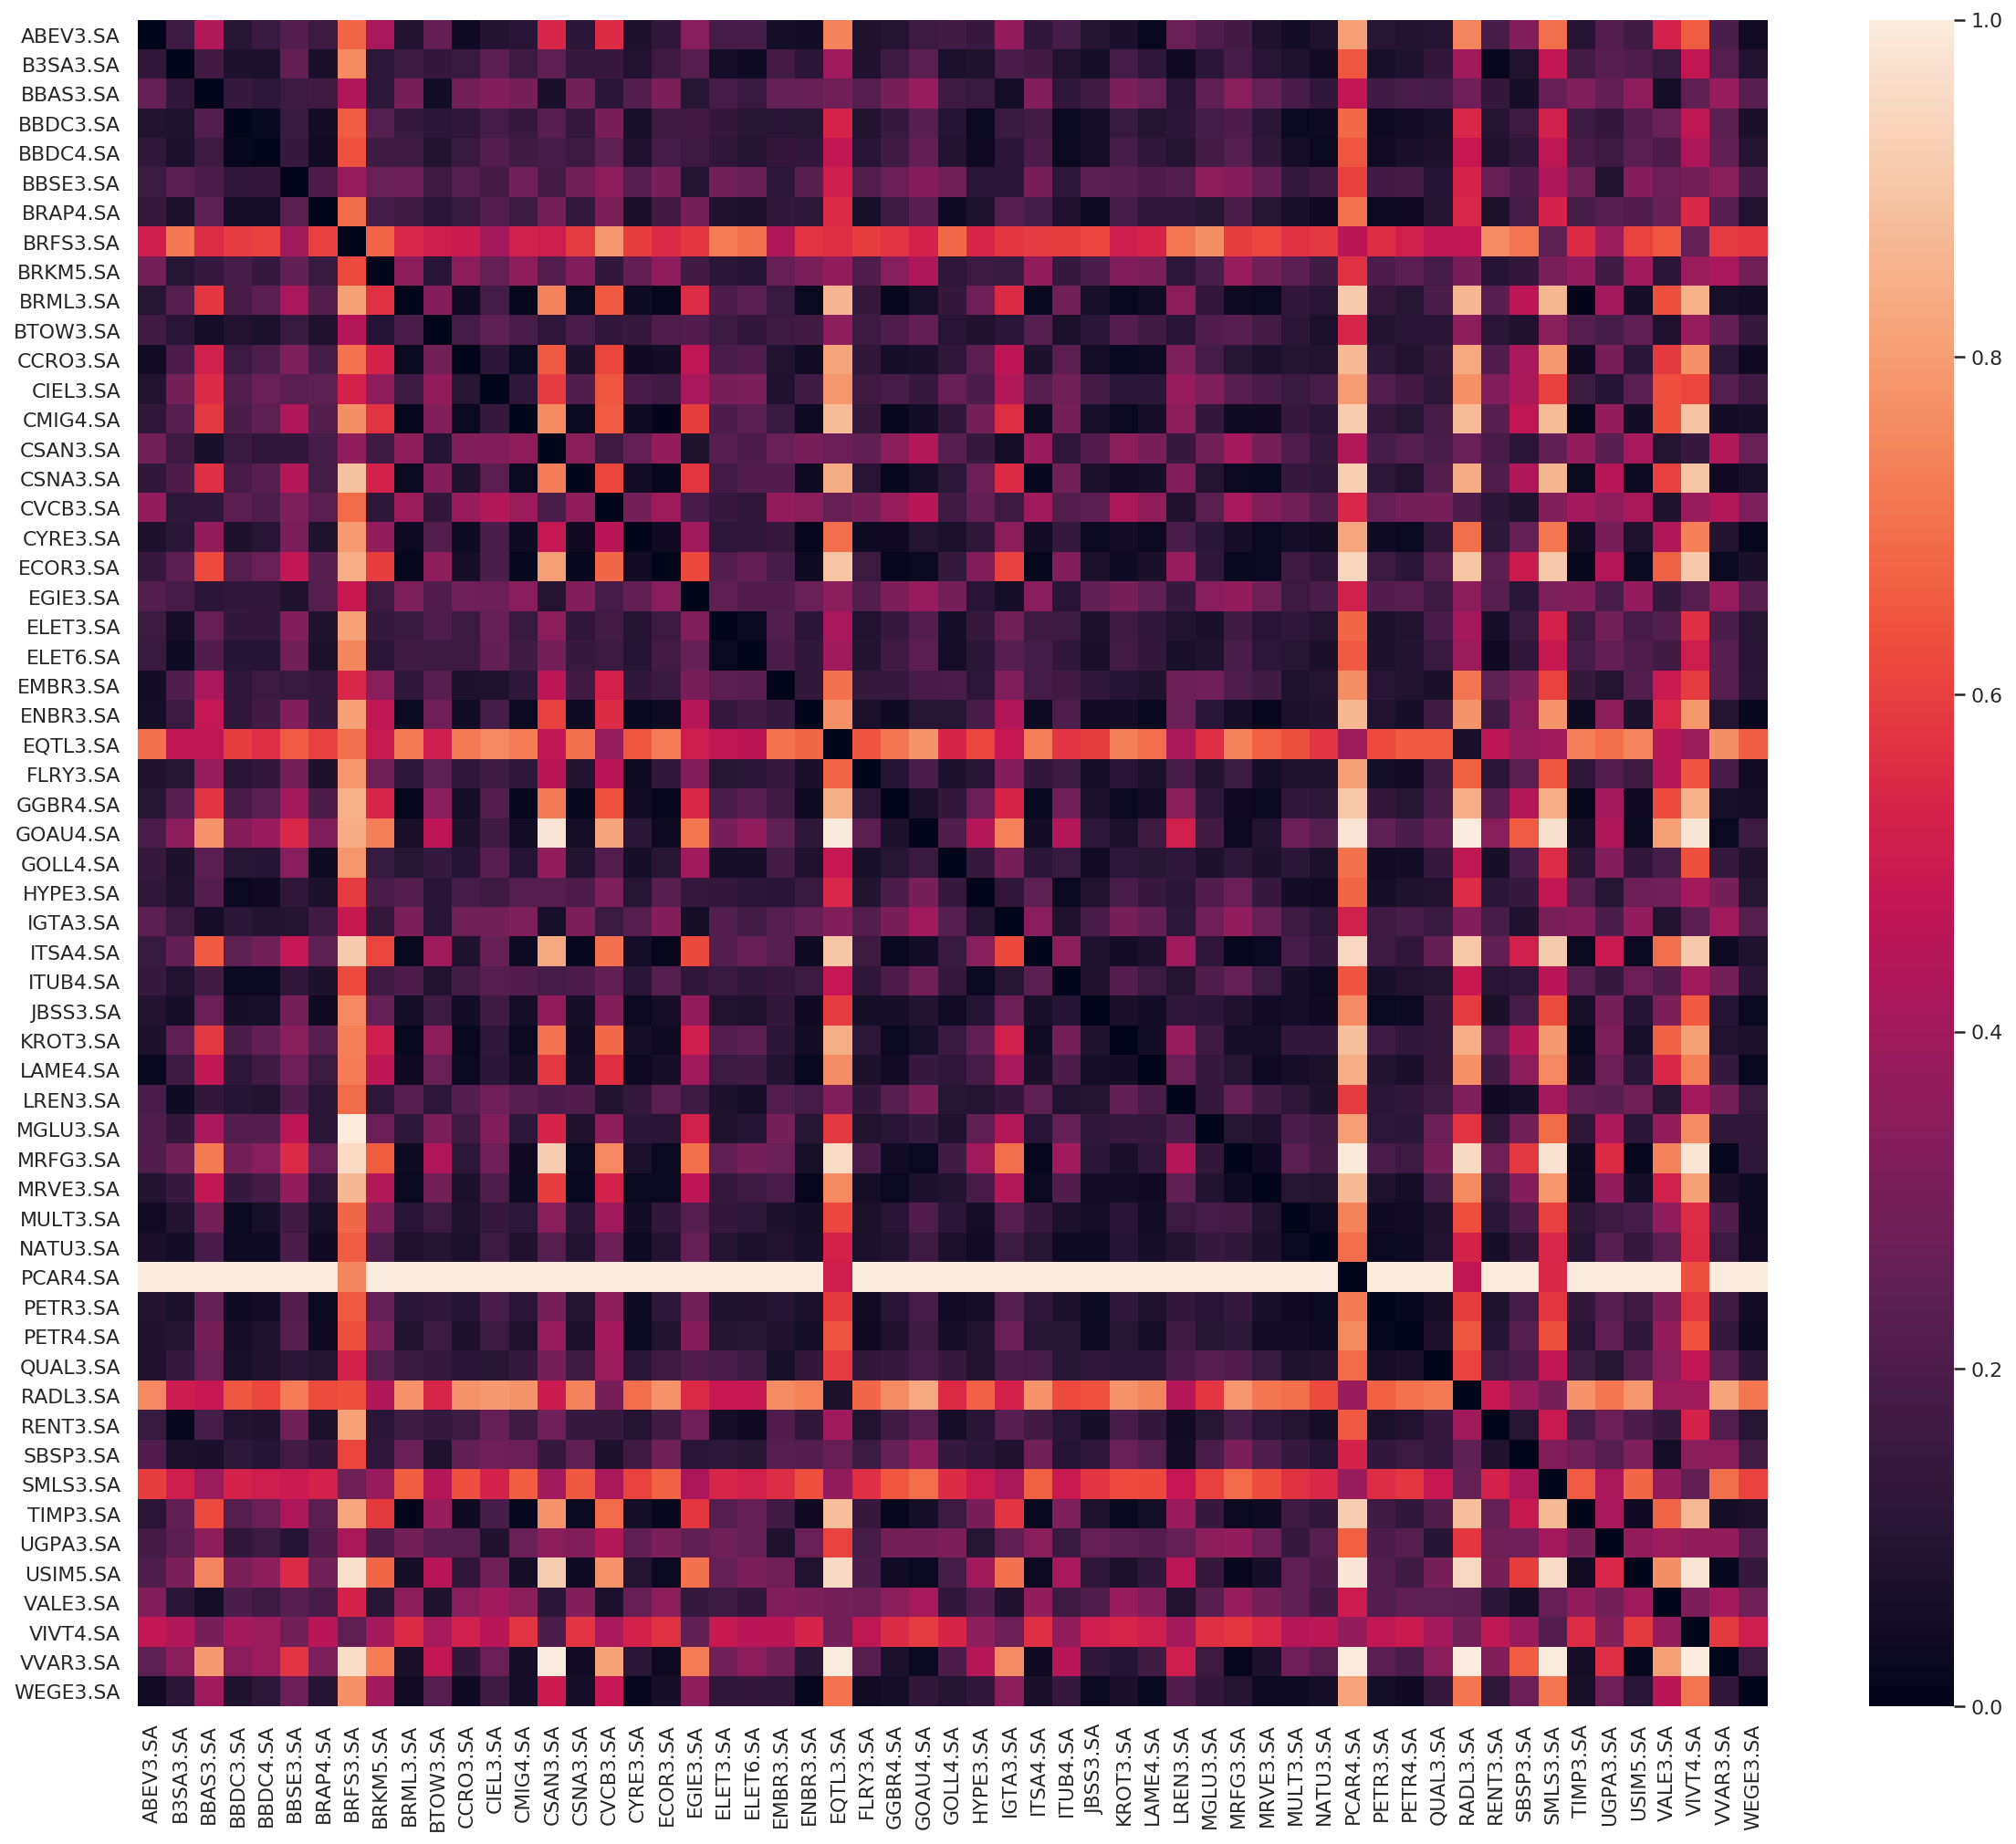

In [25]:
fig = plt.figure(figsize=[20, 17])
sns.heatmap((df_distances-df_distances.min())/(df_distances.max()-df_distances.min()))
fig.savefig("heatmap.png")

## Distancias baseada em estatística 

A biblioteca [tsfresh](https://tsfresh.readthedocs.io/en/latest/) é capaz de gerar mais de 1000 features a partir de uma serie temporal - energia, momento dentro outros.

Como são muitas dimensões, foi optado por aplicar **redução de dimensionalidade com PCA** antes de visualização e clusterização.

In [26]:
features = fresh.extract_features(df, column_sort="timestamp", column_id="ticker")

Feature Extraction: 100%|██████████| 10/10 [07:33<00:00, 45.40s/it]


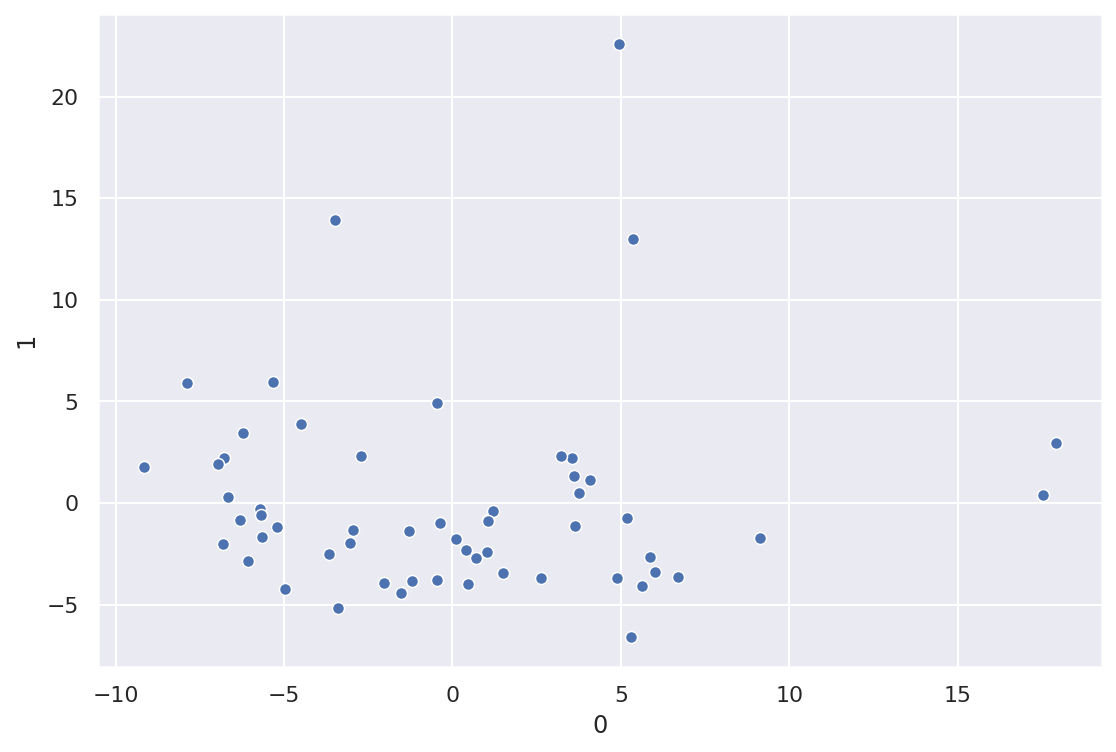

In [27]:
# Normalização dos atributos
scaler = MinMaxScaler()
feats_transformed = pd.DataFrame(scaler.fit_transform(impute(features)))

# Aplicação de PCA
pca = PCA(n_components=2)
feat_proj = pd.DataFrame(pca.fit_transform(feats_transformed))

# Visualização em duas dimensões
plt.figure(figsize=[9,6])
sns.scatterplot(x=feat_proj[0],
                y=feat_proj[1],
                palette="rainbow")

## Clustering com DBSCAN e distancias DTW

In [30]:
h = DBSCAN(metric="precomputed", eps=135, min_samples=4)
p_dtw = h.fit(df_distances)

## Clustering com DBSCAN e features estatísticos

In [31]:
h = DBSCAN(eps=4)
p_feat_proj = h.fit(feat_proj)

## Comparação dos resultados

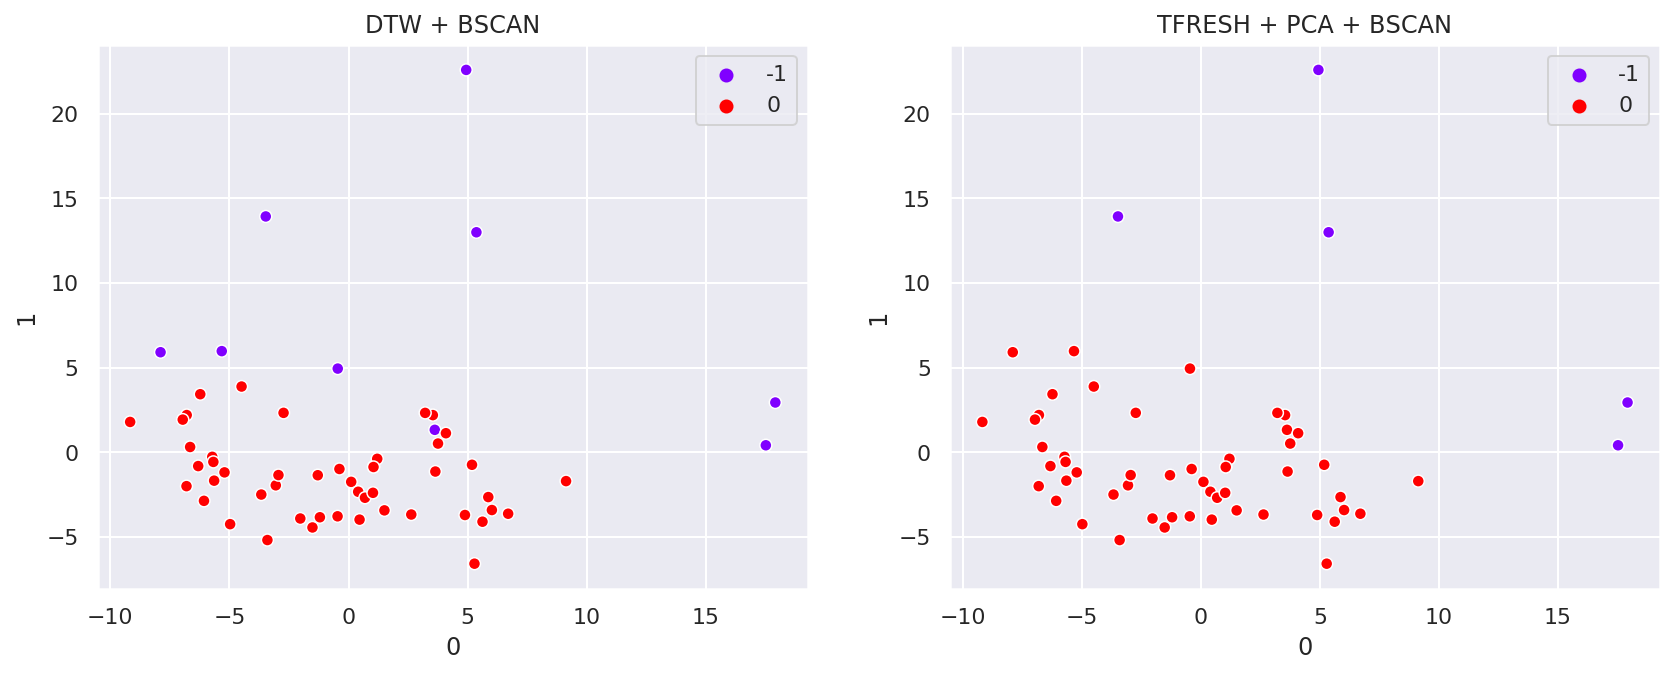

In [32]:
fig, ax = plt.subplots(1,2, figsize=[14,5])

ax[0].set_title("DTW + BSCAN")
ax[1].set_title("TFRESH + PCA + BSCAN")

sns.scatterplot(x=feat_proj[0],
                y=feat_proj[1],
                hue=p_dtw.labels_,
                ax=ax[0],
                palette="rainbow")
sns.scatterplot(x=feat_proj[0],
                y=feat_proj[1],
                hue=p_feat_proj.labels_,
                ax=ax[1],
                palette="rainbow")

Apesar da aparente homogeneidade superior da segunda abordagem foi optado por utilizar da primeira, pois o fato da distribuição dos pontos ser essa apos tsfresh + PCA pode não representar a realidade. De qualquer forma tsfresh + PCA possibilitou a visualização das series temporais em um plano bi-dimensional, o que por si já é util.

## Outliers identificados

Como a clusterização revelou que a maioria das series estão próximas umas das outras tanto com distancia DTW quanto distancia estatistica, as series que não fazem parte desse cluster principal foram consideradas outliers e eliminadas

In [33]:
bad_tickers = [a for (a,b) in (filter(lambda x: x[1] != 0, zip(unique_tickers, p_feat_proj.labels_)))]

df[~df["ticker"].isin(bad_tickers)].to_csv("filtered_tickers.csv")

# O terceiro experimento

Nesse terceiro experimento foi utilizado o dataset resultado do pre-processamento definido nos ultimos pontos. Parametros como metrica principal continuaram os mesmos e horizonte de previsão foi de 7 dias.

## Os resultados

Os melhores resultados obtidos com o dataset pre-processado foram utilizando do algoritmo XGBoost, que implementa a tecnica de gradient boosting

![bovespa-filtered-iterations](./assets/bovespa-filtered-iterations.png)

Os resultados no gráfico de previsões e dados reais foi muito melhor que o obtido no primeiro experimento e em experimentos intermediarios não documentados ( bovespa sem pre-processamento ), atingindo `r2` de 0.91,`root_mean_squared_error` de 4.06 e `normalized_root_mean_squared_error` de 0.03. 

![bovespa-filtered-pred-true](./assets/bovespa-filtered-pred-true.png)

# Testando com dados futuros reais

Agora, uma semana apos o treinamento do modelo, podemos verificar suas previsões com dados reais dos ultimos dias.

In [37]:
import pickle
import json
from sklearn.externals import joblib
from sklearn.linear_model import Ridge
from azureml.core.model import Model
import azureml.train.automl
import matplotlib.pyplot as plt

In [109]:
model_path = Model.get_model_path('model.pkl')
model = joblib.load(model_path)
forecast = model.forecast(forecast_destination=pd.Timestamp(2019, 9, 26))[1] 
forecast.reset_index(inplace=True)
forecast = forecast[forecast["timestamp"] > pd.Timestamp(2019, 9, 22)]

[21:29:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/model_wrappers.py:678: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.model.transform(X)


In [110]:
df_true = df[(df.timestamp > pd.Timestamp(2019,9,22)) & (df.timestamp < pd.Timestamp(2019,9,27))][["timestamp", "close", "ticker"]]
df_pred = forecast.rename(columns={"_automl_target_col": "close"})[["timestamp", "close", "ticker"]]

In [111]:
df_true.ticker.unique()

array(['ABEV3.SA', 'B3SA3.SA', 'BBAS3.SA', 'BBDC3.SA', 'BBDC4.SA',
       'BBSE3.SA', 'BRAP4.SA', 'BRFS3.SA', 'BRKM5.SA', 'BRML3.SA',
       'BTOW3.SA', 'CCRO3.SA', 'CIEL3.SA', 'CMIG4.SA', 'CSAN3.SA',
       'CSNA3.SA', 'CVCB3.SA', 'CYRE3.SA', 'ECOR3.SA', 'EGIE3.SA',
       'ELET3.SA', 'ELET6.SA', 'EMBR3.SA', 'ENBR3.SA', 'EQTL3.SA',
       'FLRY3.SA', 'GGBR4.SA', 'GOAU4.SA', 'GOLL4.SA', 'HYPE3.SA',
       'IGTA3.SA', 'ITSA4.SA', 'ITUB4.SA', 'JBSS3.SA', 'KROT3.SA',
       'LAME4.SA', 'LREN3.SA', 'MGLU3.SA', 'MRFG3.SA', 'MRVE3.SA',
       'MULT3.SA', 'NATU3.SA', 'PCAR4.SA', 'PETR3.SA', 'PETR4.SA',
       'QUAL3.SA', 'RADL3.SA', 'RENT3.SA', 'SBSP3.SA', 'SMLS3.SA',
       'TIMP3.SA', 'UGPA3.SA', 'USIM5.SA', 'VALE3.SA', 'VIVT4.SA',
       'VVAR3.SA', 'WEGE3.SA'], dtype=object)

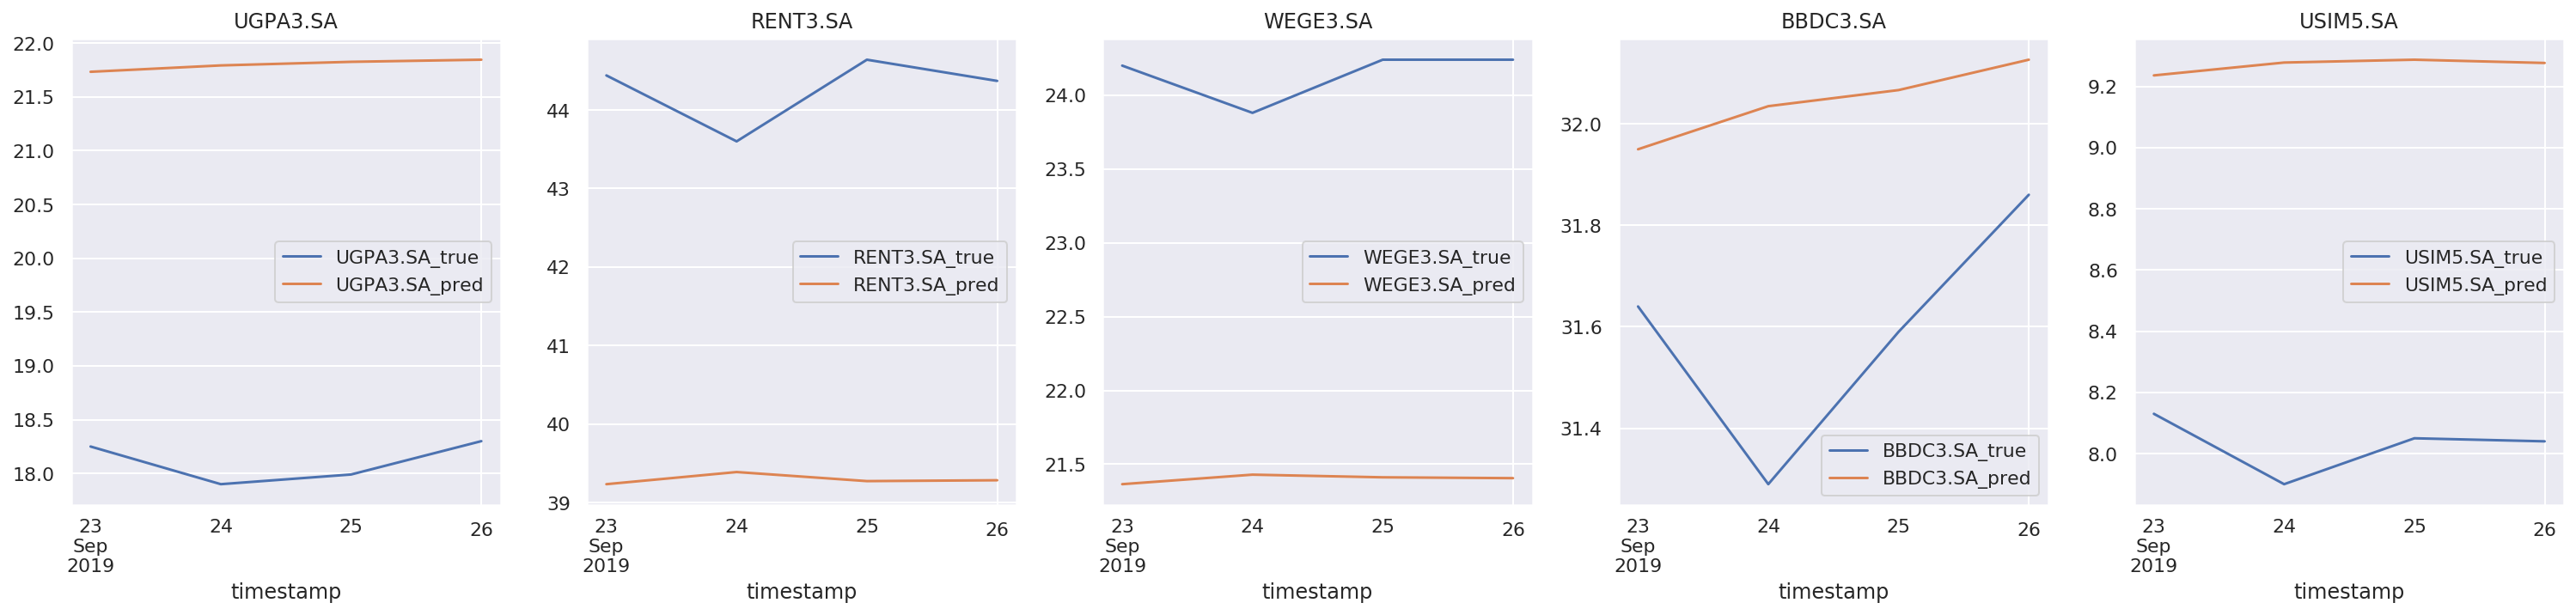

In [129]:
fig, ax = plt.subplots(1,5, figsize=[26, 5])
test_tickers = [ 'UGPA3.SA', 'RENT3.SA', 'WEGE3.SA', 'BBDC3.SA', 'USIM5.SA']

for i in range(0, len(test_tickers)):
    ax[i].set_title(test_tickers[i])
    df_true[df_true["ticker"] == test_tickers[i]].plot(x="timestamp",
                                                       y="close",
                                                       ax=ax[i],
                                                       label="{}_true".format(test_tickers[i]))
    df_pred[df_pred["ticker"] == test_tickers[i]].plot(x="timestamp",
                                                   y="close",
                                                   ax=ax[i],
                                                   label="{}_pred".format(test_tickers[i]))

# Conclusão

Apesar dos resultados terem sido razoaveis e em geral ter sido prevista a variação de alguns stocks, a regressão sempre previu um valor diferente do real. 

Talvez para ter resultados bons o suficiente para gerar dinheiro seja necessaria a analise de linguagem natural e sentimento em noticias, pois, por exemplo, no final de semana apos o treinamento do modelo ficou 